# vMF-VAE modelling for new MCMCP (study2)

## What is von Mises-Fisher distribution?
> vMF is a kind of distribution over a (d-1)-dimentional hypersphere within a d-dimensional space, which could be a uniform distribution over the sphere, or a peak centered at any given vector \mu (with a parameter kappa controlling the variance). 

## Why I plan to replace the gaussian prior with von Mises-Fisher distribution?
* Origin gravity: Gaussian prior will push data towards the origin no matter what category it is;
> First, it makes no sense to encourage all categories to cluster in the center; then, this effect will cause imbalance distributions of different clusters, hindering the diversity of generation. 
* Hard to use uniform distribution in a hyper-plane space;
* vMF provide a grace solution to uniform facial affects, which could improve the representative ability of latent space;
* Emotions' distribution is theoretically 2-d with a potential Circumplex structure (Russell, 1980), lines up well with the vMF hypersphere;
* Put affect on 2-d manifold rather than 3-d space could ease both sampling process and space mapping.

## Why use 3-d latent space?
* I think we should stay with 3-d space (with 2-d sphere in it) because we need enough space to accomodate neutral and other faces, and also we can just estimate the density over the surface of hypersphere instead of the whole space where hypersphere is embedded in.

## What do the hyper-parameters mean and why to select specific values, like kappa particularly?
* The main concern in this model's training is to find a suitable kappa for 3-d vmf distribution which is big enough (the distribution become slimmer) for generator to learn face details (e.g., kappa=1 produces a generator that is able to generate an average face merely over the latent space, with a negative diversity, and hard to be seperated into different clusters as well --- high stickiness among the data), but also not too big to avoid reconstruting the facial identity information, making the model concentrate on the facial affect, and be continuous as well. 

In [1]:
import os
import gc
import numpy as np
import torch
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from train import train
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi

from dataset import get_dataloaders
import models
from utils import setup_seed, latent_space, manifold_sphere, reconstruction, EarlyStopping

In [7]:
class config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_dim = 3  # determine shape of latent space, 2 or 3
    radius = 1.5  #controlling the radius of the hypersphere
    distribution = 'vmf'
    kappa = 300  # enough details but not too much

    data_path = "./data/cafe/balance_all"
    image_size = (64, 40)  # determine model layer size and data preprocessing: (40, 40) or (64, 40)
    label_list = {'0':'Neutral', '1':'Happy', '2':'Sad', '3':'Angry', '4':'Disgusted', '5':'Fear', '6':'Surprise'}

    weight_class = 1.0  # weight of classfier loss
    
    aug = False
    Ncrop = False
    if Ncrop:
        batchsize = 16  # with Ncrop = 5
    elif not Ncrop:
        batchsize = 64
    else:
        raise NotImplemented
    
    n_epoch = 50
    learning_rate = 1e-3
    scheduler = None  # learning rate schedule, "reduce" ...
    saved_path = "./saved_models/"
    
print(config.device)

cuda


In [3]:
# data
train_loader = get_dataloaders(path=config.data_path, bs=config.batchsize, augment=config.aug, input_size=config.image_size)

max value in image tensor is: tensor(0.8471)
size: torch.Size([64, 1, 64, 40])
tensor(1)


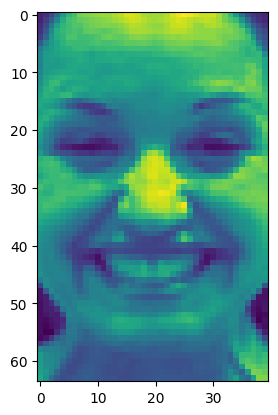

In [4]:
# show a case when augment is on
for i, data in enumerate(train_loader):
    if i==0 and config.aug and config.Ncrop:
        print('max value in image tensor is:', torch.max(data[0][0, 0, :, :]))
        print('size:', data[1].size())
        
        f, a = plt.subplots(1, 6)
        plt.setp(a.flat, xticks=[], yticks=[])
        a[0].imshow(data[0].cpu().numpy()[0, 0, :, :])
        for i in range(1, 6):
            a[i].imshow(data[1].cpu().numpy()[0, i-1, 0, :, :])
            
        print(data[2][0])

    elif i==0 and config.aug and config.Ncrop==False:
        print('max value in image tensor is:', torch.max(data[0][0, 0, :, :]))
        print('size:', data[1].size())
        
        f, a = plt.subplots(1, 2)
        plt.setp(a.flat, xticks=[], yticks=[])
        a[0].imshow(data[0].cpu().numpy()[0, 0, :, :])
        a[1].imshow(data[1].cpu().numpy()[0, 0, :, :])
            
        print(data[2][0])
        
    elif i==0 and config.aug==False and config.Ncrop==False:
        print('max value in image tensor is:', torch.max(data[0][0, 0, :, :]))
        print('size:', data[0].size())
        plt.imshow(data[0].cpu().numpy()[0, 0, :, :])
        print(data[1][0])

In [4]:
# model
s_vae = models.VAE(z_dim=config.latent_dim, 
                   size=config.image_size, 
                   distribution=config.distribution, 
                   kappa=config.kappa, 
                   radius=config.radius, 
                   device=config.device).to(config.device)  
# default as vmf-VAE
summary(s_vae, (1,)+config.image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 20]             160
         MaxPool2d-2           [-1, 16, 16, 10]               0
            Conv2d-3           [-1, 32, 16, 10]          12,832
         MaxPool2d-4             [-1, 32, 8, 5]               0
            Linear-5                   [-1, 64]          81,984
            Linear-6                    [-1, 2]             130
            Linear-7                    [-1, 1]              65
            Linear-8                   [-1, 64]             192
            Linear-9                 [-1, 1280]          83,200
  ConvTranspose2d-10           [-1, 16, 16, 10]          12,816
  ConvTranspose2d-11            [-1, 8, 32, 20]           1,160
  ConvTranspose2d-12            [-1, 1, 64, 40]              73
           Linear-13                    [-1, 7]              21
          Softmax-14                   

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'hypersphere.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


### training

In [5]:
# optimizer
optimizer = torch.optim.Adam(s_vae.parameters(), lr=config.learning_rate)
# amp: automatic mixed precision training 
scaler = GradScaler()  
# scheduler to adjust the learning rate
if config.scheduler == 'reduce':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=False)

# training
# setup_seed(0)
for epoch in range(config.n_epoch):
    rec_loss, kl_loss, cla_loss = train(s_vae, train_loader, optimizer, scaler, config)
    
    if config.scheduler == 'reduce':
        scheduler.step(rec_loss + kl_loss + cla_loss)

    print("Epoch%3d/%3d: RC_loss%8.3f, KL_loss%8.3f, CL_loss%8.3f" 
          % (epoch+1, config.n_epoch, rec_loss, kl_loss, cla_loss))
    # print("=====XXX=====")

# finish the train
model_name = "k300_e50_rd2.pt"
torch.save(s_vae, config.saved_path + model_name)
print("model has been saved as:", config.saved_path + model_name)

Epoch  1/ 50: RC_loss  11.053, KL_loss  49.050, CL_loss1870.538
Epoch  2/ 50: RC_loss  10.023, KL_loss  49.050, CL_loss1854.942
Epoch  3/ 50: RC_loss   7.900, KL_loss  49.050, CL_loss1851.497
Epoch  4/ 50: RC_loss   6.735, KL_loss  49.050, CL_loss1850.865
Epoch  5/ 50: RC_loss   6.274, KL_loss  49.050, CL_loss1851.291
Epoch  6/ 50: RC_loss   6.121, KL_loss  49.050, CL_loss1850.585
Epoch  7/ 50: RC_loss   6.054, KL_loss  49.050, CL_loss1850.450
Epoch  8/ 50: RC_loss   6.088, KL_loss  49.050, CL_loss1819.737
Epoch  9/ 50: RC_loss   5.897, KL_loss  49.050, CL_loss1793.376
Epoch 10/ 50: RC_loss   5.819, KL_loss  49.050, CL_loss1772.839
Epoch 11/ 50: RC_loss   5.765, KL_loss  49.050, CL_loss1763.541
Epoch 12/ 50: RC_loss   5.713, KL_loss  49.050, CL_loss1751.637
Epoch 13/ 50: RC_loss   5.694, KL_loss  49.050, CL_loss1741.744
Epoch 14/ 50: RC_loss   5.648, KL_loss  49.050, CL_loss1722.361
Epoch 15/ 50: RC_loss   5.652, KL_loss  49.050, CL_loss1716.266
Epoch 16/ 50: RC_loss   5.621, KL_loss  

### vasualization

In [4]:
model_name = "k300_e50_v2.pt"  # "k30_e50, k35_e50, k35_e50(2d), k35_e80(2d), k35_e80_w3(2d), k35_e80_w3(2d_40x40), k40_e80, k300_e50_v2"
model = torch.load(config.saved_path + model_name)

Number of data points: 955


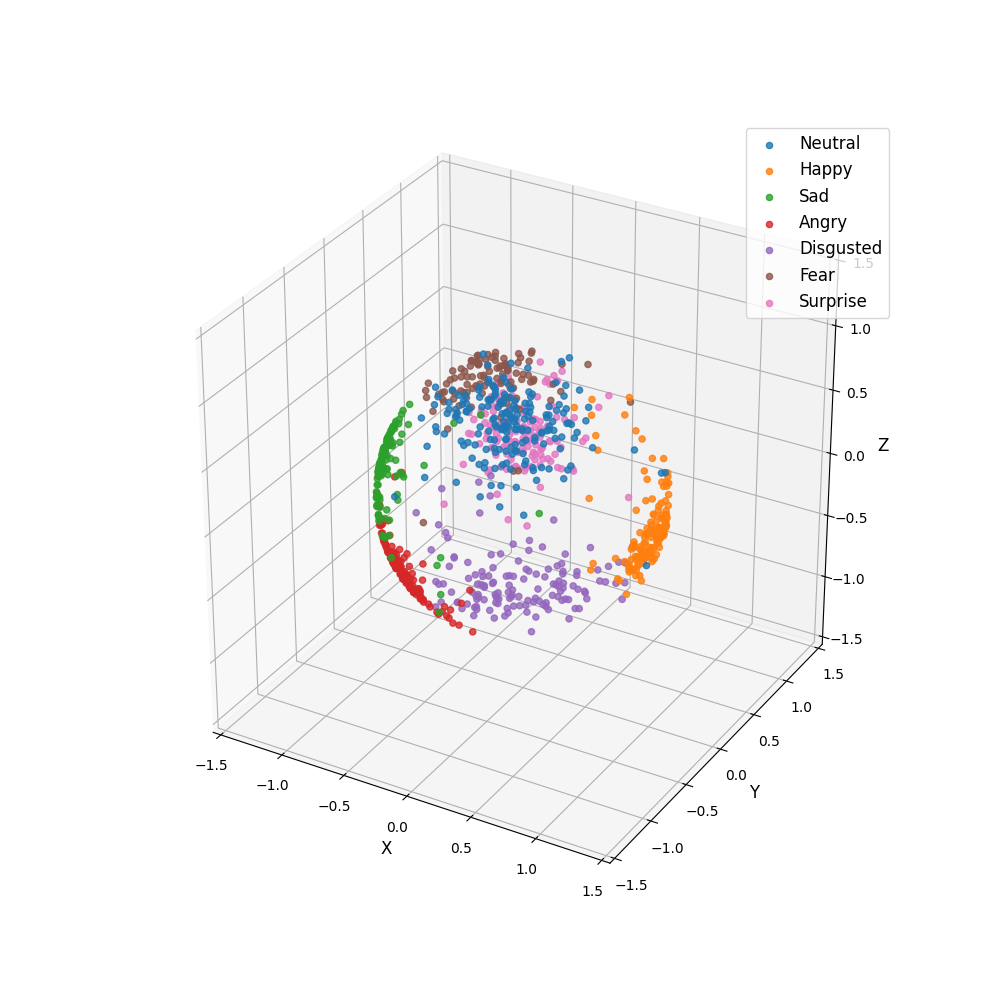

In [8]:
%matplotlib widget 
latent_space(model, train_loader, config, legend=True, sample="mean")

In [18]:
plt.close()

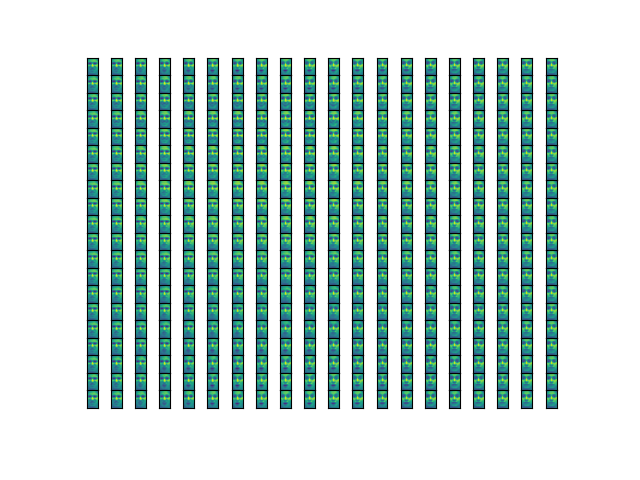

In [19]:
xy_resolution = 20
manifold_sphere(model, config, 
                theta=list(b*pi for b in np.linspace(0, 2, xy_resolution)), 
                z_resolution=20, # z_resolution works only when z_dim=3
               )  # theta belons to the range 0-2pi

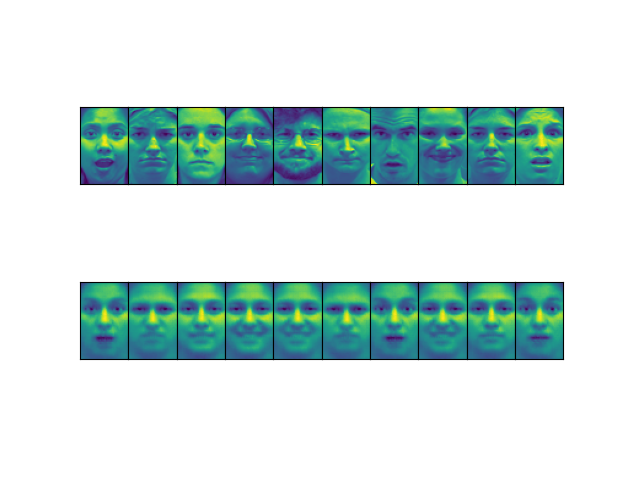

In [13]:
reconstruction(model, train_loader, n_show=10, config=config)

In [ ]:
len(train_loader)

In [3]:
from hypersphere.distributions import VonMisesFisher
%matplotlib widget 

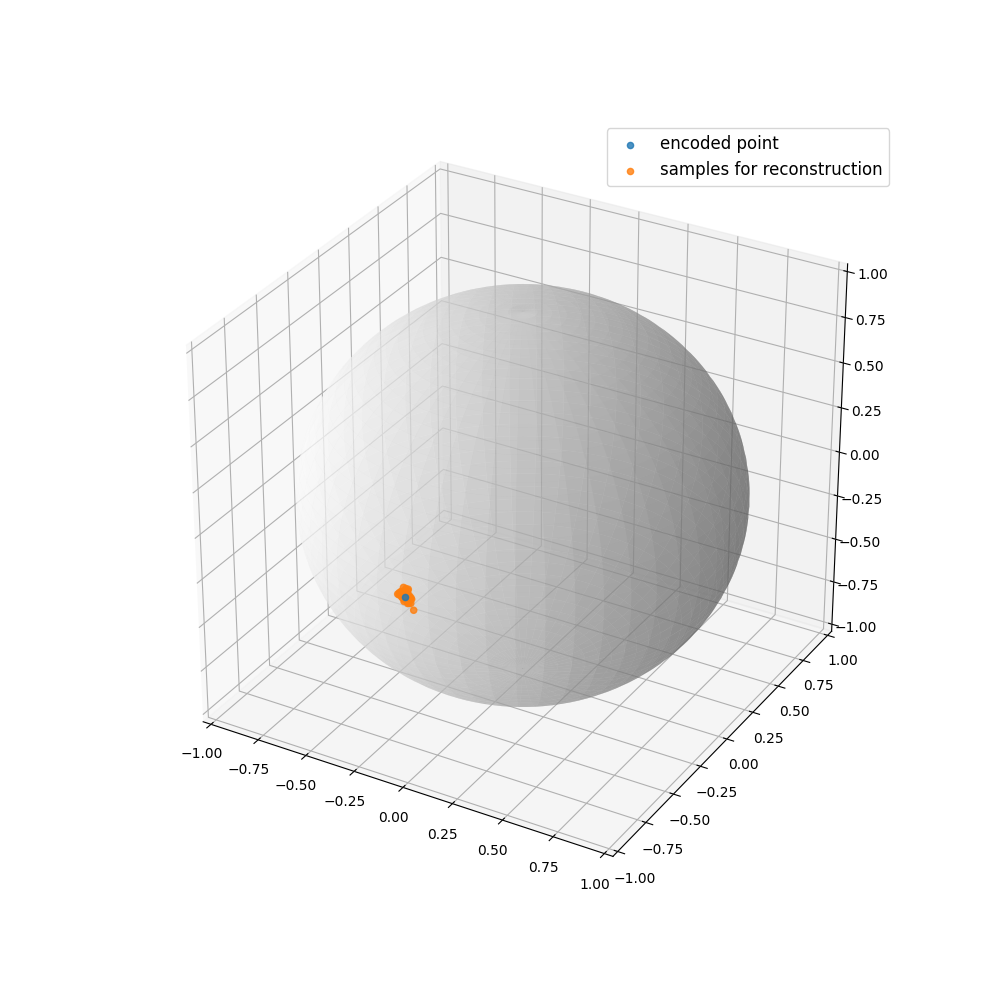

In [8]:
center = torch.tensor([[0, -1, 0]], dtype=torch.float64)
sampler = VonMisesFisher(center, torch.tensor([[1]], dtype=torch.float64), k=3000)
samples = sampler.rsample(50)[:, 0, :]
# print(samples)
ax = plt.figure(figsize=(10, 10)).add_subplot(111, projection='3d', computed_zorder=False)

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, zorder=-1, alpha=0.5, color="white")
# Set an equal aspect ratio
ax.set_aspect('equal')

ax.scatter(center[0, 0],
           center[0, 1],
           center[0, 2],
           alpha=0.8, label="encoded point", zorder=999)
ax.scatter(samples[:, 0],
           samples[:, 1],
           samples[:, 2],
           alpha=0.8, label="samples for reconstruction")

ax.legend(fontsize=12)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.show()

In [17]:
plt.close()